In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from data_tools import *
from datetime import datetime
from nls_optimizer import *
from my_time_series import tests_gaussian_white_noise
from code_alberto import get_data, get_model
import pyomo.environ as pyo
from generate_forecasts import generate_forecast
from itertools import groupby

def get_variables_data_from_pyomo_instance(instance):
    variables = dict()
    for set_name, var_list in groupby(sorted(instance.component_objects(pyo.Var), key=lambda x: x.index_set().name), key=lambda x: x.index_set().name):
        var_list = list(var_list)
        data_dict = {v.name : v.get_values().values() for v in var_list}
        index = var_list[0].index_set().data()
        df = pd.DataFrame.from_dict(data_dict).set_axis(index, axis='index')
        variables[set_name] = df
    return variables

In [2]:
dam_id = 169

path = from_id_to_time_series(dam_id)

ts = pd.read_csv(path)

observed_elevation = np.logical_not(np.isnan(ts.elevation.values))
observed_inventory = np.logical_not(np.isnan(ts.storage.values))

observed_values = np.logical_and(observed_inventory, observed_elevation)

elev_inv = zip(ts.storage.values[observed_values], ts.elevation.values[observed_values])
elev_inv = list(elev_inv)
elev_inv = sorted(elev_inv, key = lambda x:x[0])[11:] ## eliminating wrong observations
elev_inv = sorted(elev_inv, key=lambda x: x[1])

n_obs   = len(elev_inv)
n_steps = 5
step    = int(n_obs / n_steps) + 1

thersholds   = []
efficiencies = []
zd = 70
for obs in elev_inv[::step]:
    thersholds.append(obs[0])
    efficiencies.append(obs[1] - zd)
    
size = 100
dt = 0.001
times  = np.arange(0,1+dt,dt)

forecast_ele, forecast_inflow = generate_forecast(size,dt,times, 0, 1)
plt.plot(forecast_ele)
plt.show()

TypeError: generate_forecast() missing 1 required positional argument: 'seed_inflow'

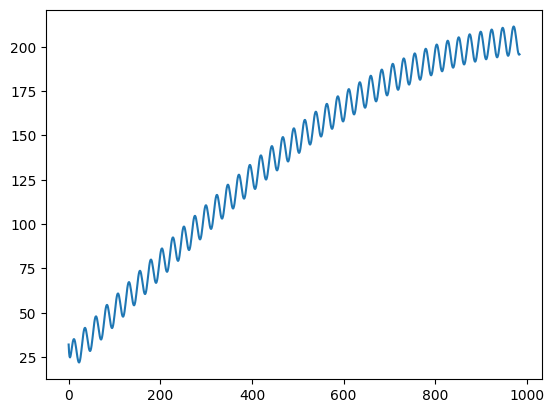

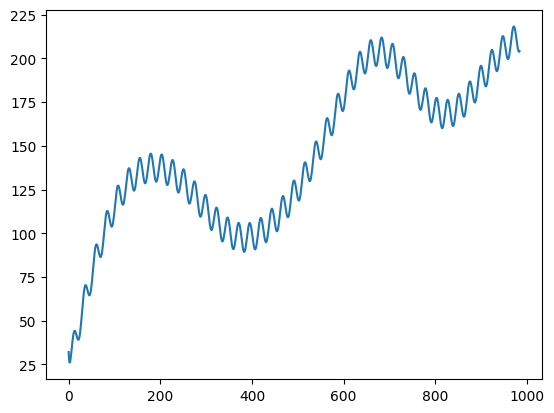

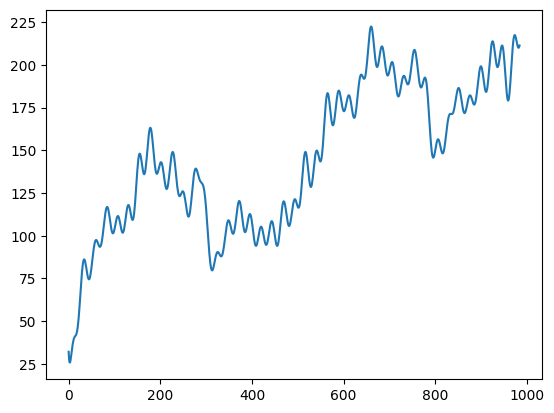

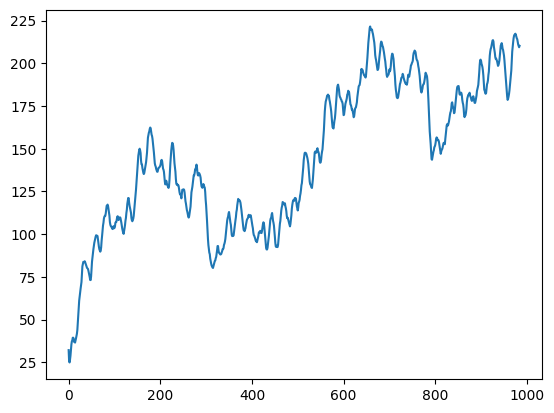

In [4]:
sizes = [1, 10, 100, 1000]

for size in sizes:
    forecast_ele, forecast_inflow = generate_forecast(size,dt,times, 0, 1)
    plt.plot(forecast_ele)
    plt.show()

In [37]:
np.logspace(1,5, num = 100,base = 10)

array([1.00000000e+01, 2.78255940e+01, 7.74263683e+01, 2.15443469e+02,
       5.99484250e+02, 1.66810054e+03, 4.64158883e+03, 1.29154967e+04,
       3.59381366e+04, 1.00000000e+05])

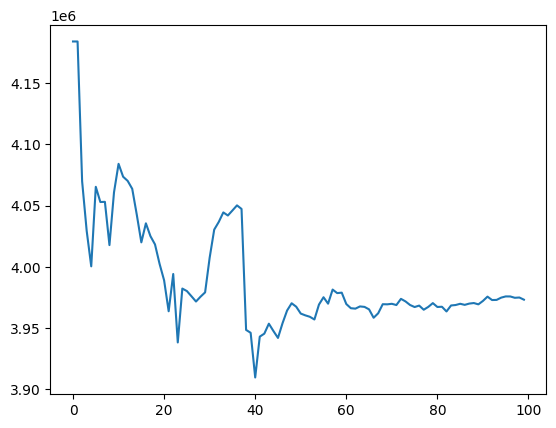

In [28]:
sizes = [1, 10, 100, 1000]
steps = int(24 * 14)
sizes = np.logspace(1,5, num = 100,base = 10)

results = []

for size in sizes:
    forecast_ele, forecast_inflow = generate_forecast(int(size),int(size),dt,times, 0, 1)
    forecast_inflow = forecast_inflow[:steps]
    forecast_ele = forecast_ele[:steps]
    
    data = get_data(list(range(len(forecast_inflow))),
                    efficiencies,
                    thersholds,
                    forecast_inflow,
                    forecast_ele)

    model = get_model()

    instance = model.create_instance(data)

    solver = pyo.SolverFactory("gurobi")

    solver.solve(instance, tee=False)
    
    results.append(instance.obj())

In [29]:
np.save("Estimates/results.npy", np.array(results))

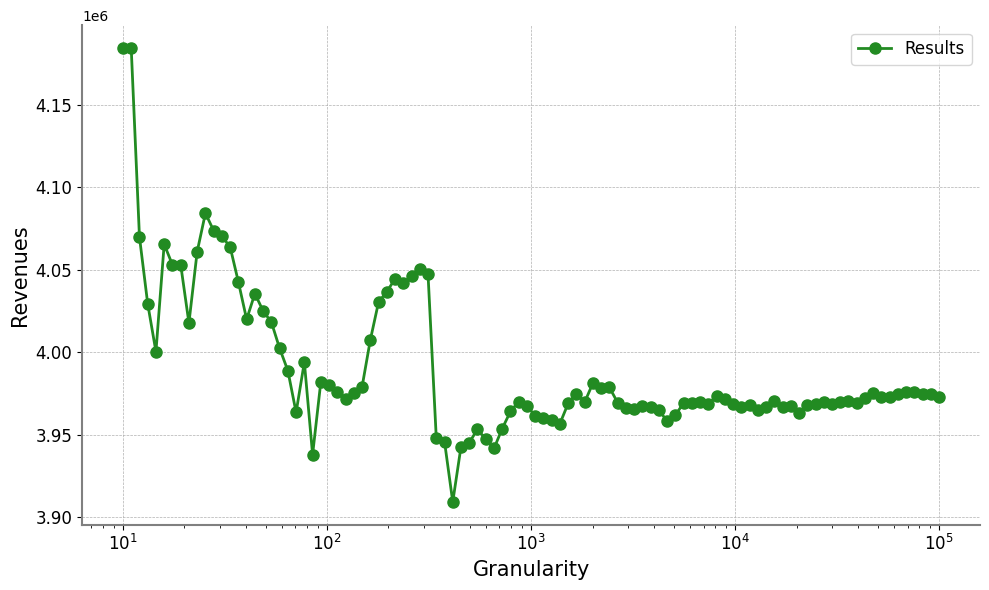

In [40]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data
ax.plot(sizes, results, color='forestgreen', marker='o', linestyle='-', linewidth=2, markersize=8)

# Add titles and labels
# ax.set_title('Revenues by Granularity', fontsize=20, fontweight='bold')
ax.set_xlabel('Granularity', fontsize=15)
ax.set_ylabel('Revenues', fontsize=15)

# Customize the ticks
ax.tick_params(axis='both', which='major', labelsize=12)

# Add gridlines
ax.grid(True, linestyle='--', linewidth=0.5)

# Remove the upper and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Optionally, you can also change the color and width of the remaining spines
ax.spines['left'].set_linewidth(1.5)
ax.spines['left'].set_color('gray')
ax.spines['bottom'].set_linewidth(1.5)
ax.spines['bottom'].set_color('gray')

ax.set_xscale('log')

# Add a legend
ax.legend(['Results'], loc='best', fontsize=12)

# Add annotations (optional)
# for i, txt in enumerate(results):
#     ax.annotate(txt, (sizes[i], results[i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=12)

# Enhance the layout
plt.tight_layout()

# Show the plot
plt.show()

In [57]:
sizes = np.logspace(1,5, num = 10,base = 10)
sizes_ele, sizes_inflow  = np.meshgrid(sizes, sizes)
sizes_ele[::-1]

steps = int(24 * 2)

results = np.zeros((len(sizes), len(sizes)))

for idx_ele in range(len(sizes)):
    for idx_inflow in range(len(sizes)):
        size_ele    = sizes_ele[   idx_ele, idx_inflow]
        size_inflow = sizes_inflow[idx_ele, idx_inflow]
        
        forecast_ele, forecast_inflow = generate_forecast(int(size_ele), int(size_inflow),dt,times, 0, 1)
        forecast_inflow = forecast_inflow[:steps]
        forecast_ele = forecast_ele[:steps]

        data = get_data(list(range(len(forecast_inflow))),
                        efficiencies,
                        thersholds,
                        forecast_inflow,
                        forecast_ele)

        model = get_model()

        instance = model.create_instance(data)

        solver = pyo.SolverFactory("gurobi")

        solver.solve(instance, tee=False)

        results[idx_ele, idx_inflow] = instance.obj()

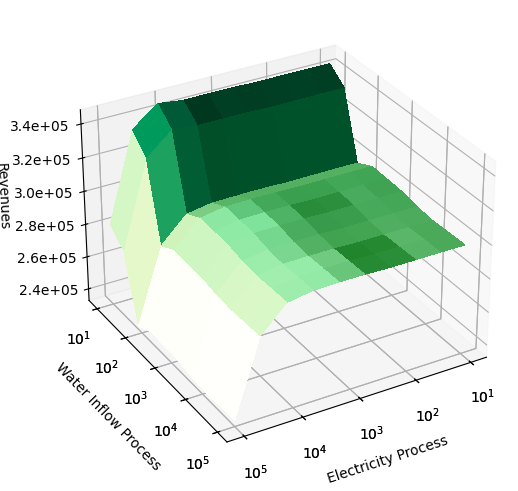

In [129]:
from matplotlib import cbook, cm
from matplotlib.colors import LightSource
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter

f = lambda x: np.log10(x)

def format_func(value, tick_number):
    return f'$10^{{{int(value)}}}$'

def format_z(value, tick_number):
    return f'{value:.1e}'


# Set up plot
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(8,6))

ls = LightSource(270, 45)
# To use a custom hillshading mode, override the built-in shading and pass
# in the rgb colors of the shaded surface calculated from "shade".
rgb = ls.shade(results, cmap=cm.YlGn, vert_exag=0.1, blend_mode='soft')
surf = ax.plot_surface(f(np.flip(sizes_ele)), f(sizes_inflow), results, rstride=1, cstride=1, facecolors=rgb,
                       linewidth=0, antialiased=False, shade=False)

ax.set_xticks(np.round(np.log10(sizes)))
ax.set_yticks(np.round(np.log10(sizes)))
ax.set_xticklabels(np.round(sizes))
ax.set_yticklabels(np.round(sizes))
ax.set_xlabel('Electricity Process', labelpad=10)
ax.set_ylabel('Water Inflow Process', labelpad=10)
ax.set_zlabel('Revenues', labelpad=16)

ax.xaxis.set_major_formatter(FuncFormatter(format_func))
ax.yaxis.set_major_formatter(FuncFormatter(format_func))
ax.zaxis.set_major_formatter(FuncFormatter(format_z))

ax.view_init(30, 60)

ax.xaxis.set_tick_params(pad=5)
ax.yaxis.set_tick_params(pad=5)
ax.zaxis.set_tick_params(pad=10)

plt.show()

In [80]:
30 * 10

300

In [7]:
data = get_data(list(range(len(forecast_inflow))),
                efficiencies,
                thersholds,
                forecast_inflow,
                forecast_ele)

model = get_model()

instance = model.create_instance(data)

solver = pyo.SolverFactory("gurobi")

solver.solve(instance, tee=True)

In [100]:
instance.obj

In [103]:
instance.obj()

75790.71158982473

75790.71158982473


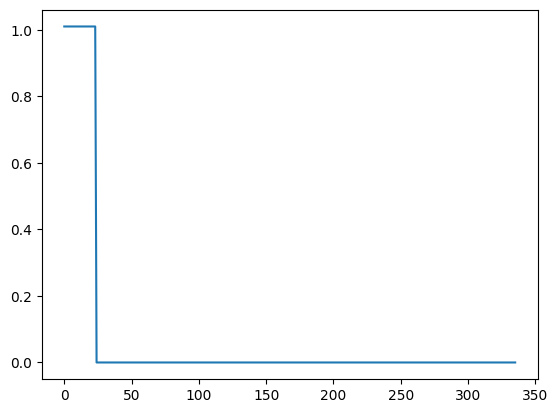

In [107]:
print(instance.obj())

results_var = get_variables_data_from_pyomo_instance(instance)

results_var['TrT'].groupby(level=1).sum()['v_outflow'].plot()
plt.show()

In [110]:
np.random.seed(0)
np.random.randn(5)

array([1.76405235, 0.40015721, 0.97873798, 2.2408932 , 1.86755799])

In [48]:
instance.values()

In [11]:
instance.obj()

75790.71158982473

In [8]:
instance.pprint()

3 Set Declarations
    T : time steps
        Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :  336 : {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187,